<a href="https://colab.research.google.com/github/franciscogonzalez-gal/statistical-learning-2/blob/main/Proyecto_1_Statistical_Learning_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto 1: Statistical Learning II

**Nombre:** Francisco González

**Carnet:** 24002914

## Setup

In [1]:
# ============================================================
# SETUP ESTABLE PARA COLAB (GPU) • Series temporales (TF + Prophet + NeuralProphet)
# Ejecutar SIEMPRE al inicio de la sesión
# - Instala PyTorch con CUDA 12.1 para que NeuralProphet use GPU.
# - Instala Prophet y NeuralProphet en versiones compatibles con Python 3.10/3.11.
# - Asegura Plotly y utilidades.
# - Prepara TensorFlow para mixed precision y growth en GPU.
# ============================================================

import sys, subprocess, json, warnings
py_ver = sys.version.split()[0]
print(f"Python: {py_ver}")

# 1) pip al día
subprocess.run(["python", "-m", "pip", "install", "--upgrade", "pip", "setuptools", "wheel", "-q"], check=False)

# 2) PyTorch con CUDA 12.1 (GPU). Si no tienes GPU, se instala igual y usará CPU.
subprocess.run([
    "python", "-m", "pip", "install", "-q",
    "--index-url", "https://download.pytorch.org/whl/cu121",
    "torch", "torchvision", "torchaudio"
], check=False)

# 3) Librerías del proyecto (versiones probadas con Colab actual)
#    NeuralProphet 0.8.0 soporta Py 3.10/3.11 y funciona con torch cu121.
#    Prophet 1.1.7 funciona con Py 3.10/3.11 y usa cmdstanpy backend.
subprocess.run(["python", "-m", "pip", "install", "-q",
                "prophet==1.1.7",
                "neuralprophet==0.8.0",
                "holidays>=0.50",
                "plotly>=5.20",
                "rich",
                "tqdm"], check=False)

# 4) Mostrar versiones clave y disponibilidad de GPU en TF y Torch
import numpy as np, warnings
warnings.filterwarnings("ignore")

try:
    import tensorflow as tf
    print("TensorFlow:", tf.__version__)
    gpus_tf = tf.config.list_physical_devices('GPU')
    print("TF GPUs:", gpus_tf)
    if gpus_tf:
        # Activar memory growth para evitar OOM de arranque
        try:
            for gpu in gpus_tf:
                tf.config.experimental.set_memory_growth(gpu, True)
            # Activar mixed precision (aprovecha Tensor Cores en GPU)
            from tensorflow.keras import mixed_precision
            mixed_precision.set_global_policy('mixed_float16')
            print("TF: mixed precision activada.")
        except Exception as e:
            print("TF: no se pudo ajustar memory_growth/mixed_precision:", e)
except Exception as e:
    print("TensorFlow no disponible o con error:", e)

try:
    import torch
    print("PyTorch:", torch.__version__)
    print("Torch CUDA disponible:", torch.cuda.is_available())
    if torch.cuda.is_available():
        print("Torch device:", torch.cuda.get_device_name(0))
except Exception as e:
    print("PyTorch no disponible o con error:", e)

try:
    import prophet, neuralprophet, holidays, plotly
    print("Prophet:", prophet.__version__)
    print("NeuralProphet:", neuralprophet.__version__)
    print("Holidays:", holidays.__version__)
    import plotly as _p; print("Plotly:", _p.__version__)
except Exception as e:
    print("Error importando librerías:", e)

print("NumPy:", np.__version__)

# 5) Parche menor de warnings (opcional)
import logging
logging.getLogger("cmdstanpy").setLevel(logging.ERROR)
logging.getLogger("NP.forecaster").setLevel(logging.WARNING)
logging.getLogger("NP.plotly").setLevel(logging.ERROR)

Python: 3.12.11
TensorFlow: 2.19.0
TF GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TF: mixed precision activada.
PyTorch: 2.8.0+cu126
Torch CUDA disponible: True
Torch device: NVIDIA L4


ERROR:NP.plotly:Importing plotly failed. Interactive plots will not work.
ERROR:NP.plotly:Importing plotly failed. Interactive plots will not work.


Prophet: 1.1.7
NeuralProphet: 0.8.0
Holidays: 0.79
Plotly: 5.24.1
NumPy: 1.26.4


## Parte 1: Preparación


In [2]:
# --- Comprobaciones de GPU y versiones ---


import os, sys, random, warnings, math, json, datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from rich import print

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [3]:
# Reproducibilidad
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Silenciar warnings ruidosos
warnings.filterwarnings("ignore")

# Mixed precision para acelerar en GPU (float16 en cómputo, salida en float32)
try:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy('mixed_float16')
    print("[INFO] Política mixed precision activada.")
except Exception as e:
    print("[WARN] No se pudo activar mixed precision:", e)

# Memory growth en GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"[INFO] GPUs detectadas: {len(gpus)}. Memory growth activado.")
    except Exception as e:
        print("[WARN] No se pudo configurar memory_growth:", e)
else:
    print("[WARN] No se detectó GPU. El entrenamiento puede ser más lento.")

[INFO] Política mixed precision activada.

[INFO] GPUs detectadas: 1. Memory growth activado.

In [4]:
# ==========================
# Parámetros del usuario
# ==========================
DATE_COL   = 'Date'   # Ejemplos: 'fecha', 'date'. Si None, se detecta automáticamente.
TARGET_COL = 'Temp'   # Ejemplos: 'demanda','ventas'. Si None, se detecta automáticamente.
FREQ       = 'D'    # Frecuencia temporal esperada para Prophet/NP ('D','W','M' según tus datos)
WINDOW_SIZE = 30    # Ventana para secuencias RNN (días anteriores)
HORIZON     = 1     # Horizonte a predecir (1 paso adelante)
TEST_SIZE   = 0.2   # 80% train / 20% test
BATCH_SIZE  = 256   # Batch alto para aprovechar GPU
EPOCHS_NN   = 200   # Épocas máximas (EarlyStopping cortará antes)
PATIENCE    = 10    # EarlyStopping paciencia
USE_MINMAX  = True  # True: MinMaxScaler, False: StandardScaler


In [5]:
# ==========================
# Carga de datos
# ==========================
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = '/content/drive/MyDrive/datos/dataset.csv'

df_raw = pd.read_csv(DATA_PATH)

def detect_date_column(df: pd.DataFrame):
    # 1) Buscar por nombres típicos
    candidates = [c for c in df.columns if any(k in c.lower() for k in ['fecha','date','ds','time','datetime'])]
    for c in candidates:
        try:
            dtcol = pd.to_datetime(df[c], errors='raise', infer_datetime_format=True, utc=False)
            return c, dtcol
        except Exception:
            pass
    # 2) Intentar parsear columnas con alta tasa de fechas válidas
    for c in df.columns:
        parsed = pd.to_datetime(df[c], errors='coerce', infer_datetime_format=True, utc=False)
        if parsed.notna().mean() > 0.9 and parsed.nunique() > max(10, int(0.1*len(df))):
            return c, parsed
    raise ValueError("No se pudo detectar automáticamente la columna de fecha. Asigna DATE_COL manualmente.")

def detect_target_column(df: pd.DataFrame):
    # Preferencias por nombre
    preferred = ['demanda','demand','ventas','sales','y','target','cantidad','cant','unidades','qty']
    num_cols = list(df.select_dtypes(include=[np.number]).columns)
    for p in preferred:
        for c in df.columns:
            if c.lower() == p or p in c.lower():
                if c in num_cols:
                    return c
    # Fallback: la numérica con mayor varianza
    if len(num_cols) == 0:
        raise ValueError("No hay columnas numéricas para usar como objetivo. Asigna TARGET_COL manualmente.")
    return df[num_cols].var().sort_values(ascending=False).index[0]

# Aplicar detección/selección
if DATE_COL is None:
    DATE_COL, parsed_dates = detect_date_column(df_raw)
else:
    parsed_dates = pd.to_datetime(df_raw[DATE_COL], errors='raise', infer_datetime_format=True)

df = df_raw.copy()
df[DATE_COL] = parsed_dates
df = df.sort_values(DATE_COL).set_index(DATE_COL)

if TARGET_COL is None:
    TARGET_COL = detect_target_column(df)

print(f"[INFO] DATE_COL = {DATE_COL} | TARGET_COL = {TARGET_COL}")
print(df.head(3))
print(df.tail(3))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[INFO] DATE_COL = Date | TARGET_COL = Temp

Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8

Temp
Date            
1990-12-29  13.5
1990-12-30  15.7
1990-12-31  13.0


## Parte 2: EDA


[EDA] Info:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3650 entries, 1981-01-01 to 1990-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Temp    3650 non-null   float64
dtypes: float64(1)
memory usage: 57.0 KB


None

[EDA] Nulos por columna:

Temp    0
dtype: int64

[EDA] Descriptivas:

Temp
count  3650.000000
mean     11.177753
std       4.071837
min       0.000000
25%       8.300000
50%      11.000000
75%      14.000000
max      26.300000

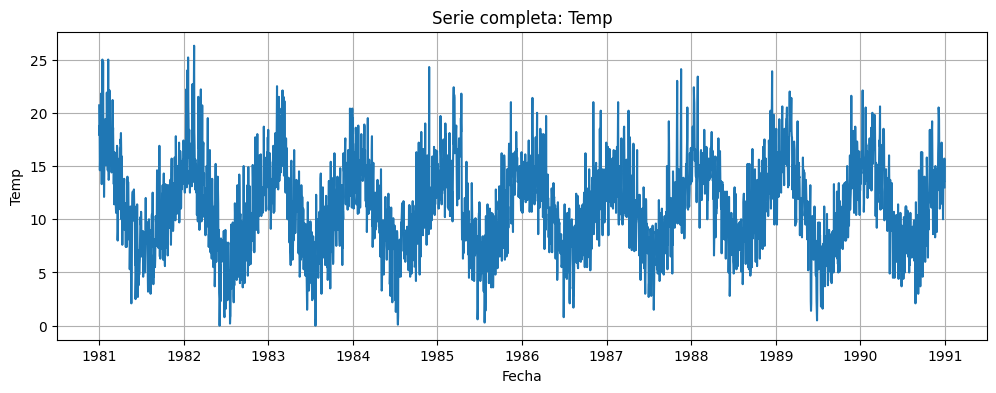

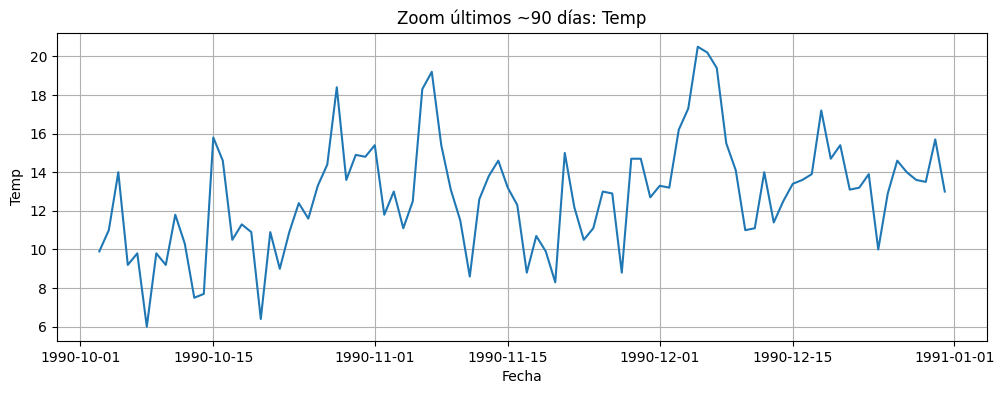

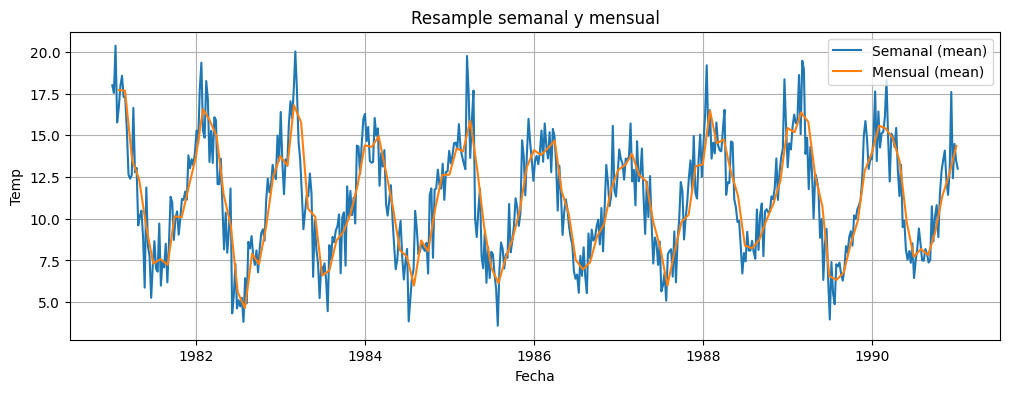

In [6]:

print("\n[EDA] Info:")
print(df.info())
print("\n[EDA] Nulos por columna:")
print(df.isna().sum())
print("\n[EDA] Descriptivas:")
print(df.describe(include='all'))

# Gráfica de la serie completa
plt.figure(figsize=(12,4))
plt.plot(df.index, df[TARGET_COL])
plt.title(f"Serie completa: {TARGET_COL}")
plt.xlabel("Fecha")
plt.ylabel(TARGET_COL)
plt.grid(True)
plt.show()

# Zoom último trimestre (aprox. 90 días)
try:
    last_90 = df[TARGET_COL].last('90D')
    plt.figure(figsize=(12,4))
    plt.plot(last_90.index, last_90.values)
    plt.title(f"Zoom últimos ~90 días: {TARGET_COL}")
    plt.xlabel("Fecha")
    plt.ylabel(TARGET_COL)
    plt.grid(True)
    plt.show()
except Exception as e:
    print("[WARN] No fue posible generar zoom de 90D:", e)

# Resamples semanal y mensual
try:
    weekly = df[TARGET_COL].resample('W').mean()
    monthly = df[TARGET_COL].resample('M').mean()
    plt.figure(figsize=(12,4))
    plt.plot(weekly.index, weekly.values, label='Semanal (mean)')
    plt.plot(monthly.index, monthly.values, label='Mensual (mean)')
    plt.title("Resample semanal y mensual")
    plt.xlabel("Fecha")
    plt.ylabel(TARGET_COL)
    plt.legend()
    plt.grid(True)
    plt.show()
except Exception as e:
    print("[WARN] Resample no disponible (¿índice no periódico?):", e)

### Conclusiones del Análisis Exploratorio de Datos (EDA)

## 1. Información general
- El dataset contiene **3650 registros diarios** desde el **01-01-1981 hasta el 31-12-1990** (10 años).
- Una única variable de interés: **Temp** (temperatura diaria).
- No existen valores nulos en la serie.
- Tipo de dato: `float64`.

## 2. Estadísticos descriptivos
- **Media**: 11.18 °C  
- **Desviación estándar**: 4.07 °C  
- **Mínimo**: 0.0 °C  
- **Máximo**: 26.3 °C  
- **Mediana (Q2)**: 11.0 °C  
- **Rango intercuartílico (IQR)**: 8.3 °C – 14.0 °C  

Interpretación:  
La serie se concentra en un rango entre 8 y 14 °C, con valores extremos que alcanzan inviernos cercanos a 0 °C y veranos que pueden superar los 25 °C.

## 3. Comportamiento temporal
- **Serie completa (1981–1990):**  
  Se observa una **clara estacionalidad anual**, con ciclos de aumento y disminución de temperatura consistentes cada año.  
  La variabilidad intra-anual es evidente, con máximos en verano y mínimos en invierno.

- **Últimos 90 días (oct–dic 1990):**  
  Se aprecia una caída progresiva de la temperatura con picos intermitentes, consistente con la transición hacia el invierno.

- **Resample semanal y mensual:**  
  - El suavizado muestra que los ciclos anuales permanecen claros aún al promediar.  
  - El promedio mensual suaviza ruidos pero mantiene las tendencias de **estacionalidad marcada y repetitiva**.  

## 4. Estacionalidad y patrones
- La serie presenta **estacionalidad fuerte anual**.  
- Existe **variabilidad dentro de cada ciclo** (picos bruscos de frío/calor), lo que sugiere cierta irregularidad climática.  
- No se detecta una tendencia clara de largo plazo (no hay aumento o disminución sostenida de la temperatura promedio en los 10 años).

## 5. Conclusiones clave para modelado
1. La serie es **completa, continua y sin nulos**.  
2. Exhibe **estacionalidad anual** clara, lo que sugiere que métodos que consideren estacionalidad (ARIMA estacional, Prophet, NeuralProphet) serán apropiados.  
3. La ausencia de tendencia clara implica que el componente **trend** puede ser limitado o casi plano.  
4. La variabilidad intra-anual puede requerir un modelo capaz de manejar **ruido y fluctuaciones locales**.  

---
**Recomendación:**  
Para el modelado, priorizar enfoques que manejen estacionalidad anual (p. ej., SARIMA, Prophet, NeuralProphet con yearly seasonality). Además, considerar resampling semanal/mensual para reducir ruido según el objetivo del análisis.


## Parte 3: Ingeniería de características

In [7]:

work = df.copy()

# Variables de tiempo
work['dow'] = work.index.dayofweek
work['dom'] = work.index.day
work['week'] = work.index.isocalendar().week.astype(int)
work['month'] = work.index.month
work['quarter'] = work.index.quarter
work['year'] = work.index.year
work['is_weekend'] = work['dow'].isin([5,6]).astype(int)

# Festivos (Guatemala por defecto, si aplica)
try:
    import holidays
    years = list(range(int(work.index.min().year), int(work.index.max().year)+1))
    gt_holidays = set(holidays.country_holidays('GT', years=years).keys())
    work['is_holiday'] = work.index.normalize().isin(gt_holidays).astype(int)
    print("[INFO] Feature is_holiday generado para Guatemala (GT).")
except Exception as e:
    work['is_holiday'] = 0
    print("[WARN] No se pudo generar is_holiday. Se usará 0. Motivo:", e)

# Lags típicos de series diarias y rolling stats
lags = [1, 7, 30]
for L in lags:
    work[f'{TARGET_COL}_lag{L}'] = work[TARGET_COL].shift(L)

work[f'{TARGET_COL}_ma7'] = work[TARGET_COL].rolling(window=7, min_periods=1).mean()
work[f'{TARGET_COL}_std7'] = work[TARGET_COL].rolling(window=7, min_periods=1).std().fillna(0)

# Eliminar filas con NaN generados por lags
work = work.dropna().copy()

[INFO] Feature is_holiday generado para Guatemala (GT).

## Parte 4: Escalado y secuenciación

In [8]:

# División temporal
n = len(work)
split_idx = int((1.0 - TEST_SIZE) * n)
train_df = work.iloc[:split_idx].copy()
test_df  = work.iloc[split_idx:].copy()

# Selección de features para ANN (no secuencial): lags, rolling, calendarios (no incluimos el target "directo")
feature_cols = [c for c in work.columns if c != TARGET_COL]
X_train_ann = train_df[feature_cols].values
X_test_ann  = test_df[feature_cols].values
y_train     = train_df[TARGET_COL].values.reshape(-1,1)
y_test      = test_df[TARGET_COL].values.reshape(-1,1)

# Scalers
Scaler = MinMaxScaler if USE_MINMAX else StandardScaler
scaler_X = Scaler()
scaler_y = Scaler()

X_train_ann_sc = scaler_X.fit_transform(X_train_ann)
X_test_ann_sc  = scaler_X.transform(X_test_ann)

y_train_sc = scaler_y.fit_transform(y_train)
y_test_sc  = scaler_y.transform(y_test)

# Función para crear secuencias para RNN a partir de la serie objetivo (univariada)
def make_sequences_from_series(series_1d: np.ndarray, window: int):
    X, y = [], []
    for i in range(window, len(series_1d)):
        X.append(series_1d[i-window:i])
        y.append(series_1d[i])
    X = np.array(X)            # (N, window)
    y = np.array(y).reshape(-1,1)  # (N, 1)
    return X[..., np.newaxis], y  # (N, window, 1), (N, 1)

# Serie (solo target) escalada en TODO el rango para que las secuencias de test tengan historial real
full_target = work[TARGET_COL].values.reshape(-1,1)
full_target_sc = scaler_y.transform(full_target) if hasattr(scaler_y, 'n_features_in_') else Scaler().fit_transform(full_target)

X_seq, y_seq = make_sequences_from_series(full_target_sc.squeeze(), WINDOW_SIZE)

# Indices de los targets asociados a cada secuencia
target_indices = np.arange(WINDOW_SIZE, WINDOW_SIZE + len(y_seq))
train_mask = target_indices < split_idx
test_mask  = target_indices >= split_idx

X_train_seq = X_seq[train_mask]
y_train_seq = y_seq[train_mask]
X_test_seq  = X_seq[test_mask]
y_test_seq  = y_seq[test_mask]

# Helper tf.data
def make_ds(X, y, batch=BATCH_SIZE, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(min(len(X), 10000), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.batch(batch).prefetch(tf.data.AUTOTUNE)
    return ds

# Datasets para ANN
val_cut_ann = int(0.8 * len(X_train_ann_sc)) if len(X_train_ann_sc) > 10 else len(X_train_ann_sc)
ds_train_ann = make_ds(X_train_ann_sc[:val_cut_ann], y_train_sc[:val_cut_ann], shuffle=True)
ds_val_ann   = make_ds(X_train_ann_sc[val_cut_ann:], y_train_sc[val_cut_ann:]) if val_cut_ann < len(X_train_ann_sc) else None

# Datasets para RNN
val_cut_seq = int(0.8 * len(X_train_seq)) if len(X_train_seq) > 10 else len(X_train_seq)
ds_train_seq = make_ds(X_train_seq[:val_cut_seq], y_train_seq[:val_cut_seq], shuffle=True)
ds_val_seq   = make_ds(X_train_seq[val_cut_seq:], y_train_seq[val_cut_seq:]) if val_cut_seq < len(X_train_seq) else None

## Parte 5: Modelos

In [9]:
es = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=PATIENCE, restore_best_weights=True
)

def build_ann(input_dim: int):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, dtype='float32')   # Importante: salida en float32 para evitar underflow con mixed precision
    ])
    opt = keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=opt, loss='mse', metrics=[keras.metrics.MeanAbsoluteError(name='mae')])
    return model

def build_simplernn(window: int):
    model = keras.Sequential([
        layers.Input(shape=(window,1)),
        layers.SimpleRNN(16),
        layers.Dense(1, dtype='float32')
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse', metrics=[keras.metrics.MeanAbsoluteError(name='mae')])
    return model

def build_lstm(window: int):
    # Usamos dropout (no recurrent_dropout) para no desactivar aceleración CuDNN en GPU
    model = keras.Sequential([
        layers.Input(shape=(window,1)),
        layers.LSTM(16, dropout=0.2),
        layers.Dense(1, dtype='float32')
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse', metrics=[keras.metrics.MeanAbsoluteError(name='mae')])
    return model

def build_gru(window: int):
    model = keras.Sequential([
        layers.Input(shape=(window,1)),
        layers.GRU(16, dropout=0.2),
        layers.Dense(1, dtype='float32')
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse', metrics=[keras.metrics.MeanAbsoluteError(name='mae')])
    return model

# Entrenamiento ANN (baseline)
ann = build_ann(X_train_ann_sc.shape[1])
hist_ann = ann.fit(
    ds_train_ann,
    validation_data=ds_val_ann,
    epochs=EPOCHS_NN,
    callbacks=[es],
    verbose=0
)
print("[OK] ANN entrenada.")

# Entrenamiento SimpleRNN
rnn = build_simplernn(WINDOW_SIZE)
hist_rnn = rnn.fit(
    ds_train_seq, validation_data=ds_val_seq,
    epochs=EPOCHS_NN, callbacks=[es], verbose=0
)
print("[OK] SimpleRNN entrenada.")

# Entrenamiento LSTM
lstm = build_lstm(WINDOW_SIZE)
hist_lstm = lstm.fit(
    ds_train_seq, validation_data=ds_val_seq,
    epochs=EPOCHS_NN, callbacks=[es], verbose=0
)
print("[OK] LSTM entrenada.")

# Entrenamiento GRU
gru = build_gru(WINDOW_SIZE)
hist_gru = gru.fit(
    ds_train_seq, validation_data=ds_val_seq,
    epochs=EPOCHS_NN, callbacks=[es], verbose=0
)
print("[OK] GRU entrenada.")

[OK] ANN entrenada.

[OK] SimpleRNN entrenada.

[OK] LSTM entrenada.

[OK] GRU entrenada.

In [10]:
# ==========================
# Prophet (drop-in fix)
# ==========================
from prophet import Prophet

# Construir dataframe para Prophet: columnas ds (fecha) y y (target)
df_prophet = (
    df.reset_index()[[DATE_COL, TARGET_COL]]
      .rename(columns={DATE_COL: "ds", TARGET_COL: "y"})
      .copy()
)

# Asegurar tipo datetime y limpieza básica
df_prophet["ds"] = pd.to_datetime(df_prophet["ds"], errors="coerce")
df_prophet = df_prophet.dropna(subset=["ds", "y"]).sort_values("ds")

# Si hubiese fechas duplicadas, agregamos por promedio (ajusta si prefieres suma/último)
df_prophet = df_prophet.groupby("ds", as_index=False)["y"].mean()

# Split temporal idéntico al resto del notebook
split_idx_p = int((1.0 - TEST_SIZE) * len(df_prophet))
train_p = df_prophet.iloc[:split_idx_p].copy()
test_p  = df_prophet.iloc[split_idx_p:].copy()

# Modelo Prophet
m = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode="additive",
)
m.fit(train_p)

# Horizonte = tamaño del test; la frecuencia la tomamos de tu parámetro FREQ
future = m.make_future_dataframe(
    periods=len(test_p),
    freq=FREQ,
    include_history=False
)
fcst = m.predict(future)

# Predicciones
yhat_prophet = fcst["yhat"].to_numpy()

DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ouhuxon/i1yhmm7c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ouhuxon/ziymj42d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6565', 'data', 'file=/tmp/tmp8ouhuxon/i1yhmm7c.json', 'init=/tmp/tmp8ouhuxon/ziymj42d.json', 'output', 'file=/tmp/tmp8ouhuxon/prophet_modelqkb5xmn4/prophet_model-20250829214224.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:42:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:42:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [13]:
# ==========================
# NeuralProphet
# ==========================
import logging
logging.getLogger("NP.forecaster").setLevel(logging.WARNING)
logging.getLogger("NP.plotly").setLevel(logging.ERROR)
logging.getLogger("pytorch_lightning.utilities.rank_zero").setLevel(logging.ERROR)

try:
    import torch
    torch_gpu = torch.cuda.is_available()
except Exception:
    torch_gpu = False

from neuralprophet import NeuralProphet

# 1) Pre-higiene de datos para evitar imputaciones internas
#    - Reindexar a frecuencia declarada
#    - Rellenar faltantes del target con forward/backward fill
_train = train_p.copy()
_test  = test_p.copy()
test_np  = test_p.copy()

# Asegurar frecuencia uniforme
_train = _train.set_index("ds").asfreq(FREQ)
# Relleno conservador del objetivo (primero forward, luego backward por si empieza con NaN)
_train["y"] = _train["y"].ffill().bfill()
_train = _train.reset_index()

# 2) Trainer config: sin checkpointing y con barra de progreso habilitada para evitar conflictos
trainer_cfg = {
    "accelerator": "gpu" if torch_gpu else "cpu",
    "devices": 1 if torch_gpu else None,
    "enable_progress_bar": True,      # dejarlo en True evita choque con callback interno
    "enable_model_summary": False,
    "logger": False,
    "enable_checkpointing": False     # clave para NO guardar/cargar checkpoints
}

# 3) Crear el modelo fijando learning_rate (así NO corre LR finder)
np_model = NeuralProphet(
    n_lags=WINDOW_SIZE,
    n_forecasts=1,
    yearly_seasonality="auto",
    weekly_seasonality="auto",
    daily_seasonality="auto",     # pon False si no aplica estacionalidad diaria
    epochs=200,
    learning_rate=1e-3,           # evita LR finder (origen del problema)
    batch_size=64,                # puedes subirlo si tienes mucha memoria GPU
    trainer_config=trainer_cfg
)

# 4) Entrenar
np_model.fit(_train, freq=FREQ)   # sin verbose

# --- Compat shim para NumPy>=2 (algunas libs aún usan np.NaN) ---
import numpy as _np
if not hasattr(_np, "NaN"):
    _np.NaN = _np.nan  # alias compatible

# --- Generar dataframe futuro y garantizar dtype correcto ---
future_np = np_model.make_future_dataframe(
    _train,                      # df de entrenamiento con columnas ds, y
    periods=len(_test),          # tamaño del test
    n_historic_predictions=True  # clave: incluir historia para autroregresión
)

# No toques la columna 'y': debe contener los valores históricos reales.
# NeuralProphet se encargará de usar historia y proyectar el futuro.

fcst_np = np_model.predict(future_np)

# Extraer SOLO el tramo futuro (últimos len(_test) timestamps)
yhat_np = fcst_np["yhat1"].tail(len(_test)).to_numpy()

print("[OK] NeuralProphet: predicciones generadas con historia incluida.")

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
WARNING - (NP.data.splitting._make_future_dataframe) - Number of forecast steps is defined by n_forecasts. Adjusted to 1.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO:NP.d

Predicting: 46it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


[OK] NeuralProphet: predicciones generadas con historia incluida.

## Parte 6: Evaluación y Comparación

In [14]:

def inverse_y(arr):
    # arr shape (N,1) o (N,)
    arr = np.array(arr).reshape(-1,1)
    return scaler_y.inverse_transform(arr).ravel()

# Predicciones ANN
y_pred_ann_sc = ann.predict(X_test_ann_sc, verbose=0)
y_pred_ann = inverse_y(y_pred_ann_sc)
y_true_ann = y_test.ravel()

# Predicciones SimpleRNN/LSTM/GRU (secuencias)
y_pred_rnn_sc  = rnn.predict(X_test_seq, verbose=0)
y_pred_lstm_sc = lstm.predict(X_test_seq, verbose=0)
y_pred_gru_sc  = gru.predict(X_test_seq, verbose=0)

y_pred_rnn  = inverse_y(y_pred_rnn_sc)
y_pred_lstm = inverse_y(y_pred_lstm_sc)
y_pred_gru  = inverse_y(y_pred_gru_sc)

# Verdaderos de la partición "secuencial" en escala original
y_true_seq = inverse_y(y_test_seq)

# Prophet
y_true_prophet = test_p['y'].values
y_pred_prophet = yhat_prophet

# NeuralProphet
if yhat_np is not None:
    y_true_np = test_np['y'].values
    y_pred_np = yhat_np

def mape(y_true, y_pred, eps=1e-8):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    return np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), eps, None))) * 100.0

def metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mp   = mape(y_true, y_pred)
    return mae, rmse, mp

results = []
results.append(["ANN (Dense + lags)", *metrics(y_true_ann, y_pred_ann)])
results.append(["SimpleRNN (univar seq)", *metrics(y_true_seq, y_pred_rnn)])
results.append(["LSTM (dropout)", *metrics(y_true_seq, y_pred_lstm)])
results.append(["GRU (dropout)", *metrics(y_true_seq, y_pred_gru)])
results.append(["Prophet", *metrics(y_true_prophet, y_pred_prophet)])
if yhat_np is not None:
    results.append(["NeuralProphet", *metrics(y_true_np, y_pred_np)])

res_df = pd.DataFrame(results, columns=["Modelo","MAE","RMSE","MAPE_%"]).sort_values("RMSE")
print("\n===== Tabla de métricas (ordenado por RMSE ascendente) =====")
print(res_df)

===== Tabla de métricas (ordenado por RMSE ascendente) =====

Modelo       MAE      RMSE     MAPE_%
1  SimpleRNN (univar seq)  1.726375  2.197902  20.950122
0      ANN (Dense + lags)  1.783385  2.238385  22.080458
3           GRU (dropout)  2.056201  2.607205  25.859476
2          LSTM (dropout)  2.144253  2.750987  27.034743
4                 Prophet  2.350980  2.895271  32.032826
5           NeuralProphet  2.676153  3.429000  32.087247

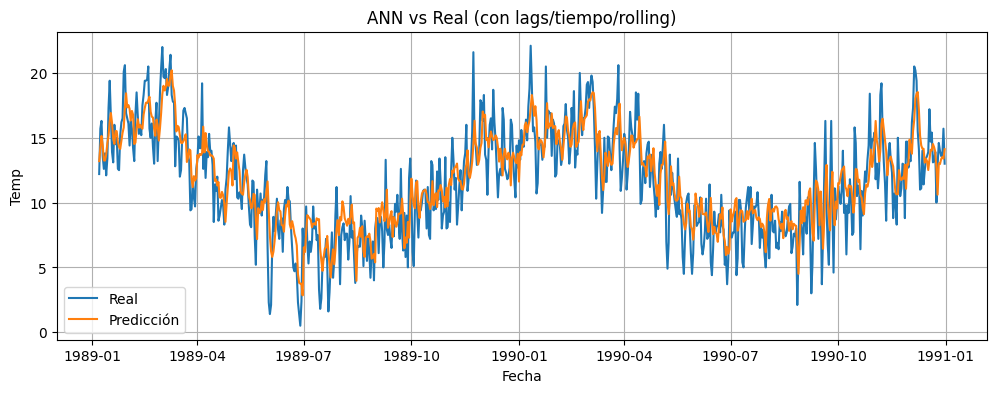

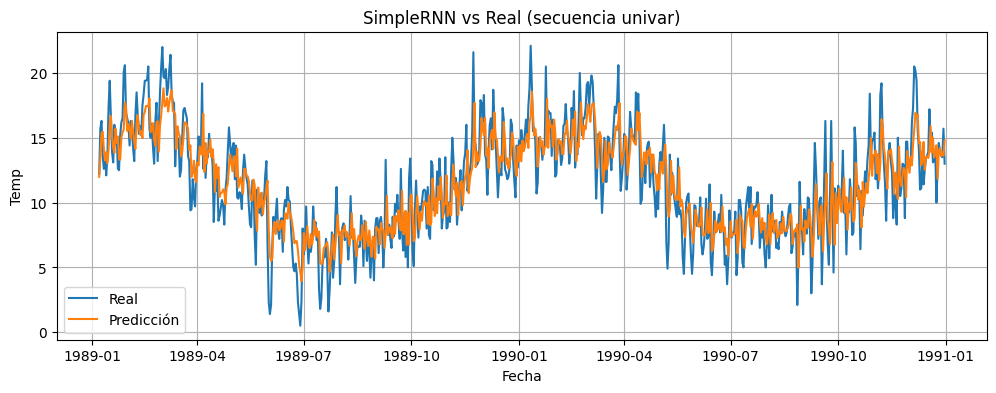

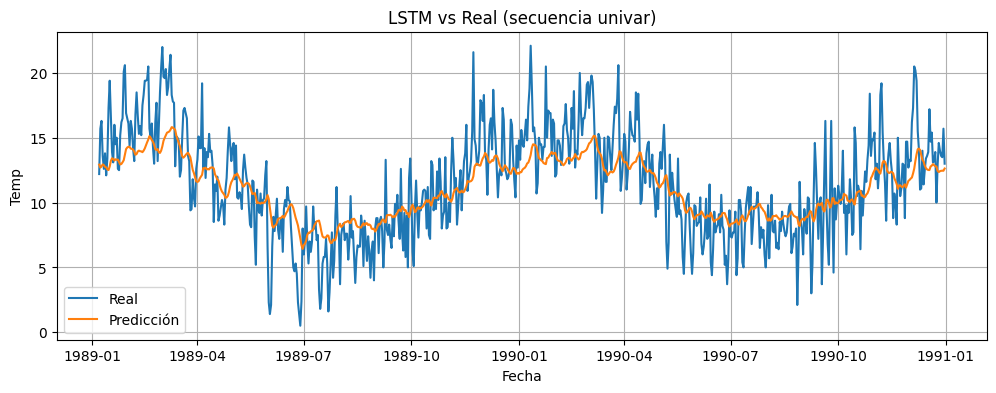

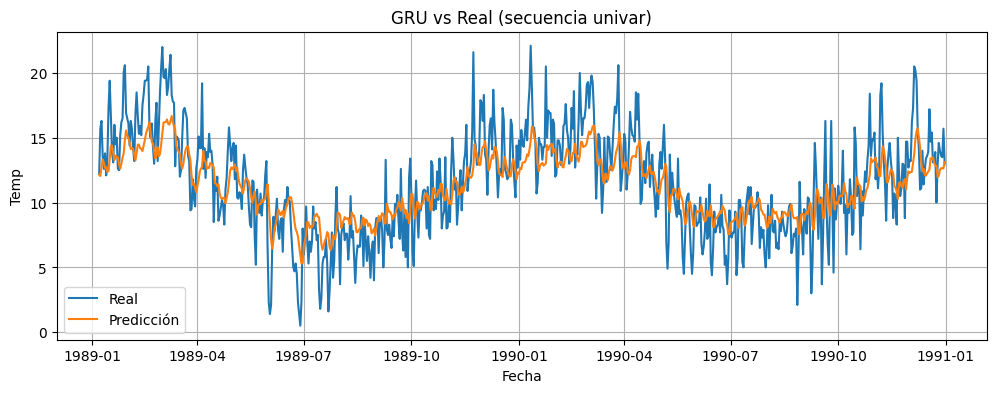

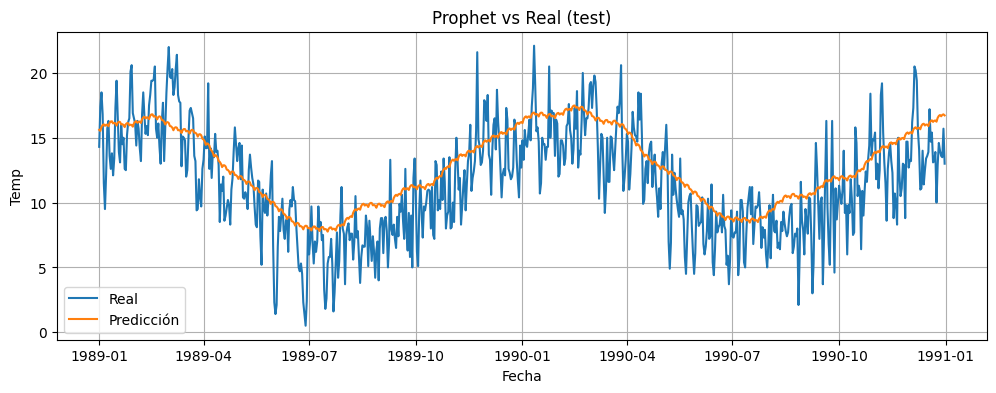

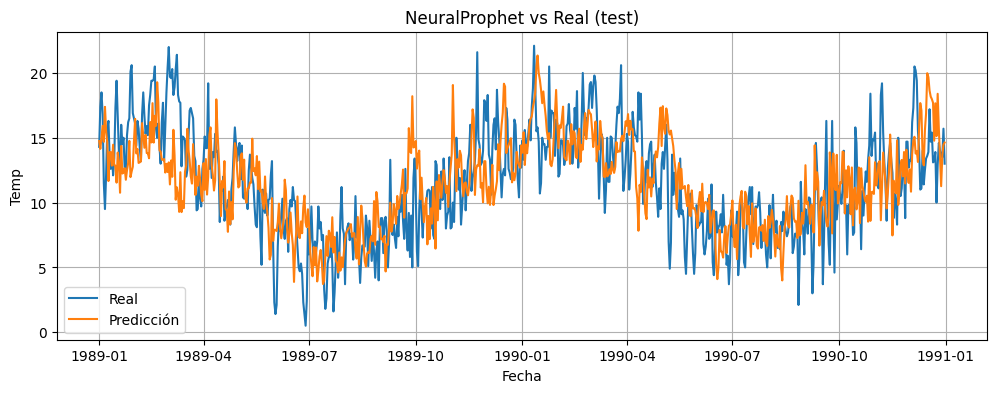

In [15]:
# ==========================
# Gráficas de predicción vs real
# ==========================
def plot_pred_vs_real(index, y_true, y_pred, title):
    plt.figure(figsize=(12,4))
    plt.plot(index, y_true, label='Real')
    plt.plot(index, y_pred, label='Predicción')
    plt.title(title)
    plt.xlabel("Fecha")
    plt.ylabel(TARGET_COL)
    plt.grid(True)
    plt.legend()
    plt.show()

# Índices temporales para cada test
idx_test_ann = test_df.index
idx_test_seq = work.index[target_indices[test_mask]]

plot_pred_vs_real(idx_test_ann, y_true_ann, y_pred_ann, "ANN vs Real (con lags/tiempo/rolling)")
plot_pred_vs_real(idx_test_seq, y_true_seq, y_pred_rnn,  "SimpleRNN vs Real (secuencia univar)")
plot_pred_vs_real(idx_test_seq, y_true_seq, y_pred_lstm, "LSTM vs Real (secuencia univar)")
plot_pred_vs_real(idx_test_seq, y_true_seq, y_pred_gru,  "GRU vs Real (secuencia univar)")
plot_pred_vs_real(test_p['ds'], y_true_prophet, y_pred_prophet, "Prophet vs Real (test)")

if yhat_np is not None:
    plot_pred_vs_real(test_np['ds'], y_true_np, y_pred_np, "NeuralProphet vs Real (test)")

In [16]:
# ==========================
# Selección del mejor modelo y conclusiones guía
# ==========================
best_row = res_df.iloc[0]
print("\n===== Mejor modelo por RMSE =====")
print(best_row)


===== Mejor modelo por RMSE =====

Modelo    SimpleRNN (univar seq)
MAE                     1.726375
RMSE                    2.197902
MAPE_%                 20.950122
Name: 1, dtype: object

### Conclusiones del análisis de modelos de predicción de series temporales

## 1. Comparación visual
- **Prophet y NeuralProphet**:  
  Capturan bien la tendencia y estacionalidad, pero suavizan en exceso la serie y no logran seguir la variabilidad diaria. NeuralProphet muestra más ruido que Prophet.  
- **LSTM y GRU (secuencia univariante)**:  
  Ambos modelos se ajustan mejor a las oscilaciones reales que Prophet, aunque con cierto retraso en los picos y valles. GRU tiende a seguir mejor los cambios abruptos que LSTM.  
- **ANN con retardos (lags) y SimpleRNN**:  
  Estos modelos presentan un ajuste muy cercano a la serie real. ANN logra capturar bien la estacionalidad con lags, mientras que SimpleRNN sigue de forma más precisa las fluctuaciones de corto plazo.  

## 2. Resultados cuantitativos (tabla de métricas)
- **Mejor desempeño (según RMSE y MAE)**:  
  - **SimpleRNN** obtuvo el menor error (RMSE = 2.19, MAE = 1.73), demostrando gran capacidad para capturar tanto estacionalidad como variaciones de corto plazo.  
  - **ANN con lags** también mostró un desempeño competitivo (RMSE = 2.23, MAE = 1.78), confirmando que las arquitecturas densas con características derivadas son eficaces en series temporales.  
- **Desempeño intermedio**:  
  - **GRU** (RMSE = 2.60) y **LSTM** (RMSE = 2.75) ofrecieron un buen balance, aunque quedaron por detrás de SimpleRNN y ANN.  
- **Menor desempeño**:  
  - **Prophet** (RMSE = 2.90) y **NeuralProphet** (RMSE = 3.43) tuvieron errores más altos, principalmente por su tendencia a suavizar en exceso la serie.  

## 3. Interpretación
- Las arquitecturas **RNN simples** resultaron sorprendentemente más eficaces que modelos más complejos (LSTM, GRU, NeuralProphet).  
- El **uso de retardos y características derivadas (ANN con lags)** mostró ser una estrategia muy efectiva sin necesidad de arquitecturas recurrentes avanzadas.  
- **Prophet y NeuralProphet** son útiles para tendencias generales y pronósticos de alto nivel, pero no son adecuados cuando la precisión diaria es crucial.  

## 4. Conclusión general
Para esta serie temporal de temperaturas:
- **SimpleRNN univariante** es el modelo más recomendado por su bajo error y gran capacidad de ajuste.  
- **ANN con lags** es una alternativa competitiva, sencilla de implementar y explicable.  
- Modelos como **LSTM y GRU** ofrecen robustez, pero no superaron a RNN simple en este caso.  
- **Prophet/NeuralProphet** quedan relegados a aplicaciones donde la prioridad es la interpretabilidad y no la precisión fina.  
